In [2]:
from ccai_client import API, File
from ccai_client.file_classes import PathologySlideNode
from histpat_toolkit.image_pyramid import DZIPyramid
from PIL import Image
from matplotlib import pyplot as plt

In [3]:
# Organization is the codename of your organization in CancerCenter.ai platform -
# usually it is the first part of the site base URL
api = API(organization='platform')

Paste the following link in your browser:

https://platform.cancercenter.ai/auth/cli/verify?<masked>


In [4]:
# To get the id of a file, folder, etc. navigate to your file in the platform and copy the id from the url
# with pattern <BASE_URL>/app/<ID>?<PARAMS>
folder = File.get(api, id='b9ae2932-0072-4505-82e2-94d26b7f96b3')

In [5]:
# Use method children to iterate over all children of the folder
for child in folder.children():
  print(child.name, child.id, child.created_at)

Gleason score dc7ce932-1f18-4438-8b07-6c42b5b5dcc3 2023-09-07 11:51:49.728865+00:00
Pathology b4e86d61-8c39-495d-a7aa-dbd90d6f8048 2023-09-04 08:41:25.158373+00:00
Radiology 771e22a8-1938-4a20-9eb9-0597a6d36e86 2023-09-04 08:45:47.772360+00:00


In [27]:
for child in folder.children():
  if isinstance(child, PathologySlideNode):
    # We can use ImagePyramid class to access the slide. You can find its documentation here:
    # https://github.com/cancercentereu/histpat-toolkit/blob/main/doc/image-pyramid.md
    dzi_pyramid = DZIPyramid(child.dzi_file)

    # We take the scale for 2x magnification. 
    # It is also possible to get scale for a specific mpp (microns per pixel)
    scale = dzi_pyramid.get_scale_for(magnification=2)
    image = dzi_pyramid.full_image(scale)
    Image.fromarray(image).save(child.name + '_2x.jpg')

    for i, mask in enumerate(child.list_tiled_masks()):
      mask_pyramid = child.get_tiled_mask_pyramid(mask)

      # Be careful: the scale of the mask pyramid is not the same as the scale of the image pyramid!
      scale = mask_pyramid.get_scale_for(magnification=2)
      mask = mask_pyramid.full_image(scale)
      Image.fromarray(mask).save(child.name + '_mask_2x_' + str(i) + '.png')

Regions of interest:
#1: Jarosław Kwiecień
Comments: []



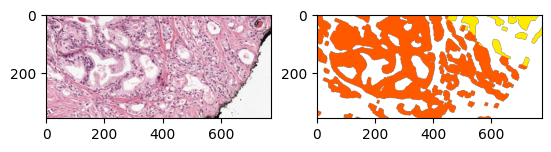

In [29]:
# We can pass the id of the slide directly to the get method
slide: PathologySlideNode = File.get(api, id='dc7ce932-1f18-4438-8b07-6c42b5b5dcc3')
dzi_pyramid = DZIPyramid(slide.dzi_file)

# We can also get all regions of interest marked on the slide
print('Regions of interest:')
for marker in slide.list_markers():
  print(f'#{marker.number}: {marker.author}')
  print('Comments:', marker.comments)
  print()

# You can download only that region of interest at a desired scale. It works for rotated ROIs too!
marker = slide.list_markers()[0]
scale = dzi_pyramid.get_scale_for(magnification=10)

# you need to pass the width of the image in pixels to the as_rectangle method
region = marker.as_rectangle(image_width=dzi_pyramid.size[0]).scale(scale)
image = dzi_pyramid.crop_rect(region, scale=scale)

plt.subplot(1, 2, 1)
plt.imshow(image)

mask = slide.list_tiled_masks()[0]
mask_pyramid = slide.get_tiled_mask_pyramid(mask)
scale = mask_pyramid.get_scale_for(magnification=10)
region = marker.as_rectangle(image_width=mask_pyramid.size[0]).scale(scale)
mask_image = mask_pyramid.crop_rect(region)

plt.subplot(1, 2, 2)
plt.imshow(mask_image)

plt.show()